In [1]:
import torch
import dataset
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [2]:
model_path = '/opt/ml/upstage_OCR/code/saved/unet_focal_2/model.pt'
state_dict_path = '/opt/ml/upstage_OCR/code/saved/unet_focal_2/best.pt'

model = torch.load(model_path)
model.load_state_dict(torch.load(state_dict_path))

ann_path = '/opt/ml/upstage_OCR/Data set/annotations/general_00_10.json'
ann_path_val = '/opt/ml/upstage_OCR/Data set/annotations/general_46_60.json'
ocr_url = "http://118.222.179.32:30000/ocr/"
image_root = '/opt/ml/upstage_OCR/Data set/real data/general'
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
transform = A.Compose([
    A.Resize(512,512),
    ToTensorV2()
])

train_dataset = dataset.WifiDataset_segmentation(ann_path,ocr_url,image_root,transform=transform)
val_dataset = dataset.WifiDataset_segmentation(ann_path_val,ocr_url,image_root,transform=transform)

  0%|          | 0/14 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
load images ...


  0%|          | 0/15 [00:00<?, ?it/s]

loading annotations into memory...
Done (t=0.00s)
load images ...


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


In [3]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=4,
                                           shuffle=True,
                                           collate_fn=collate_fn)
val_dataloader = torch.utils.data.DataLoader(dataset=val_dataset, 
                                           batch_size=4,
                                           shuffle=True,
                                           collate_fn=collate_fn)

x,y,meta = next(iter(train_dataloader))

In [4]:
meta

([{'id': 12,
   'width': 384,
   'height': 398,
   'file_name': 'general008.jpg',
   'license': 0,
   'flickr_url': '',
   'coco_url': '',
   'date_captured': 0}],
 [{'id': 9,
   'width': 296,
   'height': 301,
   'file_name': 'general079.jpg',
   'license': 0,
   'flickr_url': '',
   'coco_url': '',
   'date_captured': 0}],
 [{'id': 6,
   'width': 1200,
   'height': 675,
   'file_name': 'general005.jpg',
   'license': 0,
   'flickr_url': '',
   'coco_url': '',
   'date_captured': 0}],
 [{'id': 3,
   'width': 800,
   'height': 1067,
   'file_name': 'general002.jpg',
   'license': 0,
   'flickr_url': '',
   'coco_url': '',
   'date_captured': 0}])

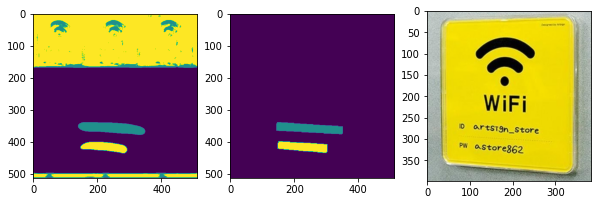

In [5]:
import matplotlib.pyplot as plt
import torchvision
import os
from PIL import Image
import numpy as np

idx = 0
model.eval()
image = model(torch.stack(x).to(device))[idx]
out = torch.argmax(image,dim=0)
image_meta = meta[idx][0]

raw_image = Image.open(os.path.join(image_root,image_meta['file_name']))
t = A.Compose([
    A.Resize(image_meta['height'],image_meta['width']),
    ToTensorV2()
])
t2 = torchvision.transforms.ToPILImage()

plt.figure(figsize=(10,10))

plt.subplot(1,3,1)
plt.imshow(t2(out*0.3))

plt.subplot(1,3,2)
plt.imshow(t2(y[idx]*0.3))

plt.subplot(1,3,3)
plt.imshow(raw_image)

plt.show()